In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import logging
import sys, os

from scipy.stats.mstats import winsorize
from scipy.stats import shapiro, mannwhitneyu

from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, make_scorer,
                             f1_score, roc_auc_score, auc, roc_curve, r2_score, mean_squared_error)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier          
from sklearn.pipeline import Pipeline    
from sklearn.inspection import PartialDependenceDisplay

import xgboost as xgb

from src.preprocessing import winsorize_columns
import backtest

In [2]:
# Add src/ to the Python path
sys.path.append(os.path.join(os.getcwd(), "src"))
from main import preprocess
# Run the preprocessing pipeline and get final DataFrame
final_df = preprocess()
final_df.head()

/Users/arshsingh/Documents/Montclair/portfolio-masters-capstone/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/arshsingh/Documents/Montclair/portfolio-masters-capstone/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Unnamed: 0.1,Unnamed: 0,date_x,symbol_fin,reportedCurrency_x,cik_x,fillingDate_x,acceptedDate,calendarYear_x,period_x,...,rnd_to_revenue_roll8,inventory_to_assets_roll4,inventory_to_assets_roll8,future_date,future_price,future_dji,log_dji_return,log_return_future,relative_log_return,good_stock
0,63111,75310,1999-12-31,DOX,USD,1062579.0,2000-01-05,2000-01-05,2000,Q1,...,0.063694,0.000000,0.000000,2000-06-08,58.586189,1461.670044,0.041601,0.715895,0.674294,1
1,130799,153831,1999-11-25,MCS,USD,62234.0,2000-01-07,2000-01-07,1999,Q4,...,0.000000,0.000000,0.000000,2000-04-07,4.356047,1516.349976,0.050643,-0.240857,-0.291499,0
2,141749,166758,1999-11-30,MTRX,USD,866273.0,2000-01-13,2000-01-13,2000,Q2,...,0.000000,0.035111,0.035111,2000-04-13,2.437500,1440.510010,-0.006346,-0.248461,-0.242116,0
3,188722,222772,1999-11-30,SKY,USD,90896.0,2000-01-13,2000-01-13,1999,Q3,...,0.000000,0.044463,0.044463,2000-08-04,13.072436,1462.930054,0.009098,-0.197612,-0.206711,0
4,196657,232068,1999-11-30,STRL,USD,874238.0,2000-01-14,2000-01-14,1999,Q4,...,0.000000,0.267070,0.267070,2000-07-19,1.187500,1481.959961,0.011408,-0.051293,-0.062701,0


Processing sector: Financial Services
Top Spearman correlations with good_stock:
Book_Value_per_share                     0.093722
totalInvestments                         0.078453
longTermInvestments                      0.075621
cashAndShortTermInvestments              0.074485
shortTermInvestments                     0.074447
totalStockholdersEquity                  0.074431
totalEquity                              0.073456
totalLiabilitiesAndStockholdersEquity    0.072704
totalLiabilitiesAndTotalEquity           0.072704
totalAssets                              0.072246
goodwill                                 0.070383
goodwillAndIntangibleAssets              0.068773
totalLiabilities                         0.067798
future_dji                               0.065927
totalDebt                                0.062451
intangibleAssets                         0.062307
totalNonCurrentAssets                    0.060591
cash_ratio                               0.060161
salesMaturitiesOfIn

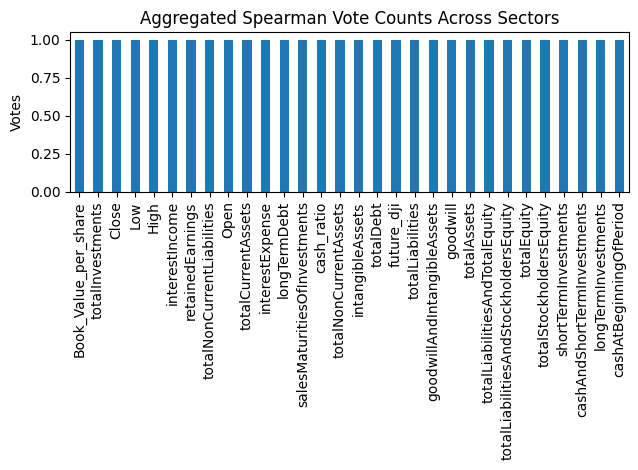

In [3]:
# Using Spearman correlations here as it is better when it comes to handling a binary target variable and non-linear relationships

# List the columns to ignore
ignore_cols = [
    'good_stock', 'calendarYear', 'calendarYear_y', 'calendarYear_x', 
    'Adj Close', 'quarter_number', 'future_price', 
    'cik_x', 'cik_y', 'cik', 'Unnamed: 0.1', 'Unnamed: 0',
    'Return_future', 'relative_return', 'relative_log_return', 'log_return_future'  
]


fin_df = final_df[final_df['Sector'] == 'Financial Services']
# Get unique sectors (doesn't matter here since it is just one sector)
sectors = fin_df['Sector'].unique()

# Dictionary to store Spearman correlations for each sector
sector_spearman = {}

# Set how many top features per sector to consider as votes
top_n_per_sector = 30

# FGilter the dataframe per sector
for sector in sectors:
    print(f"Processing sector: {sector}")
    
    df_sector = fin_df[fin_df['Sector'] == sector].copy()

    df_sector_numeric = df_sector.select_dtypes(include=['number'])
    
    df_sector_numeric = df_sector_numeric.drop(columns=ignore_cols, errors='ignore')
    
    # Ensure the 'good_stock' column is present 
    if 'good_stock' not in df_sector.columns:
        print(f"Skipping sector '{sector}': 'good_stock' column not found.")
        continue
    
    df_sector_numeric['good_stock'] = df_sector['good_stock']
    
    spearman_corr = df_sector_numeric.corr(method='spearman')['good_stock'].drop('good_stock')
    
    # Sort features by the absolute Spearman correlation (descending) and take the top N features
    top_spearman = spearman_corr.abs().sort_values(ascending=False).head(top_n_per_sector)
    sector_spearman[sector] = top_spearman
    
    print("Top Spearman correlations with good_stock:")
    print(top_spearman)
    print("-" * 50)

# Aggregate the top features (votes) across sectors and count how many times each feature appears in the top lists
all_votes = []
for sector, top_feats in sector_spearman.items():
    all_votes.extend(top_feats.index.tolist())

vote_counts = Counter(all_votes)
vote_counts_df = pd.DataFrame.from_dict(vote_counts, orient='index', columns=['Votes'])
vote_counts_df = vote_counts_df.sort_values(by='Votes', ascending=False)

print("Aggregated Spearman vote counts across sectors:")
print(vote_counts_df)

vote_counts_df.plot(kind='bar', title='Aggregated Spearman Vote Counts Across Sectors', legend=False)
plt.ylabel('Votes')
plt.tight_layout()
plt.show()

In [4]:
fin_df = final_df[final_df['Sector'] == 'Financial Services'].copy()
fin_df['accepted_date'] = pd.to_datetime(fin_df['accepted_date'])

# Time-based train/test split to avoid lookahead bias/leakage
# Sometimes, these type of models can end up remembering companies
train_cutoff = pd.Timestamp("2016-01-01")
test_cutoff_end = pd.Timestamp("2023-03-31")

train_df = fin_df[fin_df['accepted_date'] < train_cutoff].copy()
test_df  = fin_df[(fin_df['accepted_date'] >= train_cutoff) & (fin_df['accepted_date'] <= test_cutoff_end)].copy()

target = 'good_stock'
features = [
    'ROA', 'ROE', 'ROI',
    'revenue_growth_quarterly', 'revenue_growth_annual', 'Profit_Margin',
    'PB_ratio', 
    'Deferred_Revenue_to_Current_Liabilities', 'Deferred_Revenue_to_Revenue', 
    'cash_ratio', 'debt_ratio',
    'totalInvestments_to_assets',  
    'ROE_lag1', 
    'epsdiluted_lag1', 'epsdiluted_lag4', 
    'ROE_roll4', 'ROE_roll8', 'ROA_roll4', 'ROA_roll8',   
    'free_cash_flow_yield_roll8',
    'Profit_Margin_roll4',
    'epsdiluted'
]

# Replace infinities and drop missing values
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna(subset=features + [target])
test_df = test_df.replace([np.inf, -np.inf], np.nan).dropna(subset=features + [target])

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


# As a model that predicts returns, a high accuracy (80-100%) is unlikely. In that case, the model is probably struggling
# with overfitting. The philosophy then would be to avoid bad investments. If we are creating a portfolio, the last thing
# we want to do is lose money. From there, the model should have a pool of stocks it considers healthy that it can then buy. 
def custom_recall_scorer(y_true, y_pred):
    """
    Computes the harmonic mean of recall for class 0 and class 1,
    but if recall for class 0 (not good) is less than 0.90, returns 0.
    This forces the grid search to favor models that have at least 90% recall for class 0.
    """
    recall0 = recall_score(y_true, y_pred, pos_label=0)
    recall1 = recall_score(y_true, y_pred, pos_label=1)
    if recall0 < 0.90:
        return 0.0
    if recall0 + recall1 == 0:
        return 0.0
    return 2 * (recall0 * recall1) / (recall0 + recall1)

custom_scorer = make_scorer(custom_recall_scorer, greater_is_better=True)

# Grid Search using the custom scorer
tscv = TimeSeriesSplit(n_splits=3)
# param_grid_rf = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'max_features': [None, 'sqrt', 'log2']
# }

param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_split': [2],
    'max_features': [None]
}

rf_clf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid_rf,
                              scoring=custom_scorer,
                              cv=tscv,
                              verbose=1,
                              n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search_rf.best_params_)

best_rf_model = grid_search_rf.best_estimator_

# Model evaluation on the test set
y_pred = best_rf_model.predict(X_test)
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))

Train shape: (10141, 22)
Test shape: (8172, 22)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters found:
{'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.91      0.71      4763
           1       0.47      0.11      0.18      3409

    accuracy                           0.58      8172
   macro avg       0.53      0.51      0.44      8172
weighted avg       0.54      0.58      0.49      8172

Confusion Matrix:
[[4340  423]
 [3041  368]]
Accuracy: 0.5761135584924131
Precision: 0.46523388116308473
Recall: 0.10794954532120857
F1 Score: 0.17523809523809525
ROC AUC: 0.5305207523008928



Feature Importances:
cash_ratio                                 0.136414
epsdiluted_lag4                            0.124326
PB_ratio                                   0.078215
revenue_growth_annual                      0.072396
debt_ratio                                 0.062824
epsdiluted_lag1                            0.060746
totalInvestments_to_assets                 0.059744
epsdiluted                                 0.035997
ROI                                        0.035183
free_cash_flow_yield_roll8                 0.034346
Profit_Margin_roll4                        0.034292
ROE                                        0.033455
ROA_roll4                                  0.031776
revenue_growth_quarterly                   0.030852
ROE_lag1                                   0.029544
ROE_roll4                                  0.028259
ROA                                        0.027449
ROA_roll8                                  0.022429
Profit_Margin                             

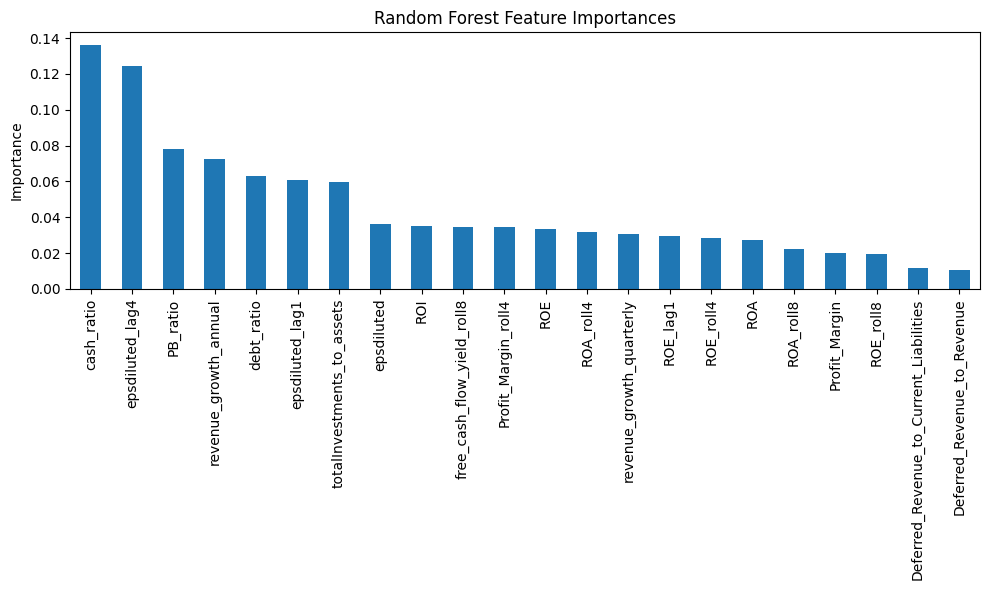

In [5]:
# Random Forests are extremely helpful in problems like this because of their ability to offer
# feature importances. In this case, we can see that cash ratio and EPS are the clear important features.
# This is reasonable as liquidity and earnings are extremely crucial in the Financial Services sector.
importances = best_rf_model.feature_importances_
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Valid Trades Summary (first few rows):
  symbol_stock          entry_date           exit_date  trade_return  \
0           AB 2018-02-13 07:02:10 2019-02-13 07:17:51      0.279085   
1         ACGL 2019-05-07 16:40:24 2019-08-07 11:57:11      0.153410   
2         ACGL 2021-05-06 14:43:28 2021-08-05 14:41:29     -0.008468   
3          AGM 2022-05-09 16:13:40 2022-08-08 16:13:00      0.047393   
4          AGM 2022-11-07 16:13:38 2023-02-24 08:07:19      0.223550   

   position_size  hold_periods          exit_reason Quarter  
0    1394.143731             2        signal_change  2019Q1  
1     625.415945             2        signal_change  2019Q3  
2     528.859408             2        signal_change  2021Q3  
3     208.114351             2  fundamentals_change  2022Q3  
4     185.964696             2        signal_change  2023Q1  

Enhanced Trade-Level Backtest Performance:
Quarterly Trade Returns:
 2016Q1   -0.010000
2016Q2    0.078714
2016Q3    0.079243
2016Q4    0.067612
2017Q1    

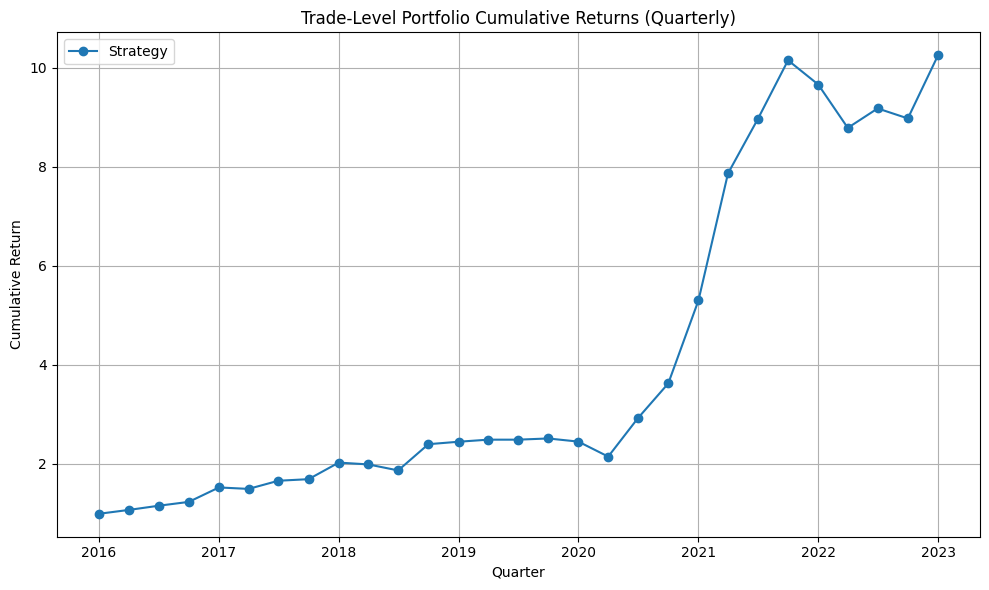

In [6]:
# To hold a more realistic portfolio, we use the enhanced backtest to account for holding a stock until the signal changes - 
# either due to a negative return, a deterioration of fundamentals, or a threshold for profit/loss. 

# Enhanced Backtest

transaction_cost = 0.005  # 0.5% per trade side
slippage = 0.002          # 0.2% slippage per trade side

# Add predictions to test_df
predicted_signal = best_rf_model.predict(X_test)
test_df.loc[X_test.index, 'predicted_signal'] = predicted_signal

test_sim = test_df.sort_values(['symbol_stock', 'accepted_date']).copy()

# Select simulation function

# simulation_function = backtest.simulate_trades_for_stock_baseline
simulation_function = backtest.simulate_trades_for_stock_enhanced

all_trades = []
for symbol, group in test_sim.groupby('symbol_stock'):
    trades = simulation_function(group, transaction_cost, slippage,
                                 stop_loss=-0.05, take_profit=1.0,
                                 max_hold_periods=20, risk_per_trade=1000, account_balance=100000)
    all_trades.extend(trades)

trades_df = pd.DataFrame(all_trades)

if not trades_df.empty:
    trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
    trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])
    trades_df['Quarter'] = trades_df['exit_date'].dt.to_period('Q')
    
    # Exclude trades that were force-closed immediately (no holding period).
    valid_trades_df = trades_df[trades_df['entry_date'] < trades_df['exit_date']]
    
    print("Valid Trades Summary (first few rows):")
    print(valid_trades_df.head())
    
    quarterly_trade_returns = valid_trades_df.groupby('Quarter')['trade_return'].mean()
    all_quarters = pd.period_range(start=test_sim['accepted_date'].min().to_period('Q'),
                                   end=test_sim['accepted_date'].max().to_period('Q'),
                                   freq='Q')
    quarterly_trade_returns = quarterly_trade_returns.reindex(all_quarters, fill_value=-0.01)
    
    cumulative_returns = (1 + quarterly_trade_returns).cumprod()
    n_quarters = len(cumulative_returns)
    observed_annualized_return = (cumulative_returns.iloc[-1]) ** (4 / n_quarters) - 1
    sharpe_ratio = quarterly_trade_returns.mean() / quarterly_trade_returns.std() * np.sqrt(4)
    
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    print("\nEnhanced Trade-Level Backtest Performance:")
    print("Quarterly Trade Returns:\n", quarterly_trade_returns)
    print("Cumulative Portfolio Returns:\n", cumulative_returns)
    print(f"Observed Annualized Return: {observed_annualized_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns.index.to_timestamp(), cumulative_returns, marker='o', label='Strategy')
    plt.title("Trade-Level Portfolio Cumulative Returns (Quarterly)")
    plt.xlabel("Quarter")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No trades were generated from the simulation.")

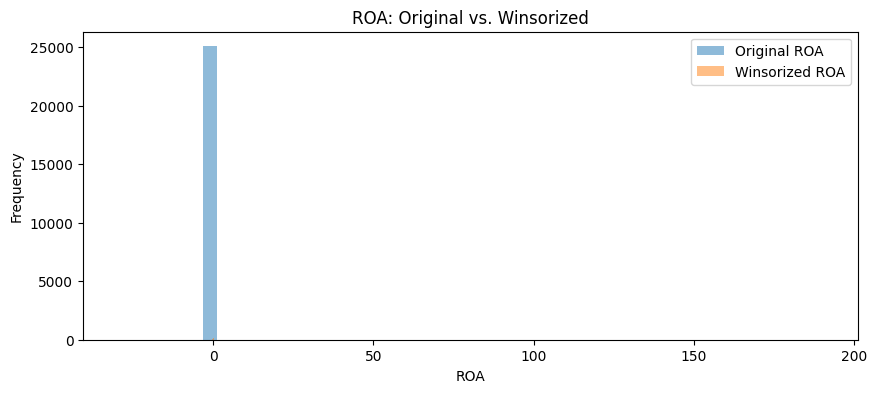

ROA - Original summary:
count    25065.000000
mean         0.019580
std          1.670036
min        -29.574964
25%          0.001877
50%          0.003175
75%          0.007970
max        190.190769
Name: ROA, dtype: float64

ROA - Winsorized summary:
count    25065.000000
mean         0.005954
std          0.056987
min         -2.000000
25%          0.001877
50%          0.003175
75%          0.007970
max          2.000000
Name: ROA_win, dtype: float64


In [ ]:
# Winsorization

fin_df = final_df[final_df['Sector'] == 'Financial Services'].copy()

# Replace infinities with NaN
fin_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define columns for winsorization

# 1. Fixed-limit winsorization columns: return/efficiency ratios
fixed_limit_cols = [
    'ROA', 'ROE', 'ROI', 'ROE_lag1', 'ROE_roll4', 'ROE_roll8',
    'ROA_roll4', 'ROA_roll8', 'Profit_Margin', 'Profit_Margin_roll4'
]

# 2. EPS-related features
eps_cols = ['epsdiluted', 'epsdiluted_lag1', 'epsdiluted_lag4']

# 3. Valuation and liquidity measures (add to fixed_limit_cols)
fixed_limit_cols.extend(['PB_ratio', 'cash_ratio', 'free_cash_flow_yield_roll8'])

# 4. Quantile-based winsorization columns: growth and investments
quantile_cols = ['revenue_growth_quarterly', 'revenue_growth_annual', 'totalInvestments_to_assets']

# 5. Columns to be left untouched
untouched_cols = ['debt_ratio']

# Set fixed limits for the fixed-limit columns
# -----------------------------
fixed_limits = {
    # Return and efficiency ratios
    'ROA': (-2, 2),
    'ROE': (-2, 2),
    'ROI': (-2, 2),
    'ROE_lag1': (-2, 2),
    'ROE_roll4': (-2, 2),
    'ROE_roll8': (-2, 2),
    'ROA_roll4': (-2, 2),
    'ROA_roll8': (-2, 2),
    'Profit_Margin': (-2, 2),
    'Profit_Margin_roll4': (-2, 2),
    # Valuation and liquidity measures
    'PB_ratio': (0, 10),
    'cash_ratio': (0, 20),
    'free_cash_flow_yield_roll8': (-5, 5),
    # EPS-related features
    'epsdiluted': (0, 20),
    'epsdiluted_lag1': (0, 20),
    'epsdiluted_lag4': (0, 20)
}

# Define Winsorization functions
def winsorize_fixed(series, lower, upper):
    """Clip series values to the fixed [lower, upper] range."""
    return series.clip(lower, upper)

def winsorize_quantile(series, lower_quantile=0.05, upper_quantile=0.95):
    """Clip series values to the range defined by the quantiles."""
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower_bound, upper_bound)


# 1. Fixed-limit winsorization for fixed_limit_cols and eps_cols
for col in fixed_limit_cols + eps_cols:
    if col in fin_df.columns:
        lower, upper = fixed_limits[col]
        fin_df[col + '_win'] = winsorize_fixed(fin_df[col], lower, upper)

# 2. Quantile-based winsorization for growth/investment metrics
for col in quantile_cols:
    if col in fin_df.columns:
        fin_df[col + '_win'] = winsorize_quantile(fin_df[col])

# 3. Columns to be left untouched are copied
for col in untouched_cols:
    if col in fin_df.columns:
        fin_df[col + '_win'] = fin_df[col]

# Visualization and summary for a selected feature
valid_ROA = fin_df['ROA'][np.isfinite(fin_df['ROA'])].dropna()
valid_ROA_win = fin_df['ROA_win'][np.isfinite(fin_df['ROA_win'])].dropna()

plt.figure(figsize=(10, 4))
plt.hist(valid_ROA, bins=50, alpha=0.5, label='Original ROA')
plt.hist(valid_ROA_win, bins=50, alpha=0.5, label='Winsorized ROA')
plt.title('ROA: Original vs. Winsorized')
plt.xlabel('ROA')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print("ROA - Original summary:")
print(valid_ROA.describe())
print("\nROA - Winsorized summary:")
print(valid_ROA_win.describe())

Train shape: (10141, 20)
Test shape: (8172, 20)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters found:
{'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.91      0.72      4763
           1       0.47      0.11      0.18      3409

    accuracy                           0.58      8172
   macro avg       0.53      0.51      0.45      8172
weighted avg       0.54      0.58      0.49      8172

Confusion Matrix:
[[4346  417]
 [3038  371]]
Accuracy: 0.5772148800783162
Precision: 0.47081218274111675
Recall: 0.10882956878850103
F1 Score: 0.17679294734334047
ROC AUC: 0.5284635765806718

Feature Importances:
cash_ratio_win                    0.126135
epsdiluted_lag4_win               0.124257
PB_ratio_win                      0.082912
revenue_growth_annual_win         0.069929
debt_ratio_win                    0.067111
totalIn

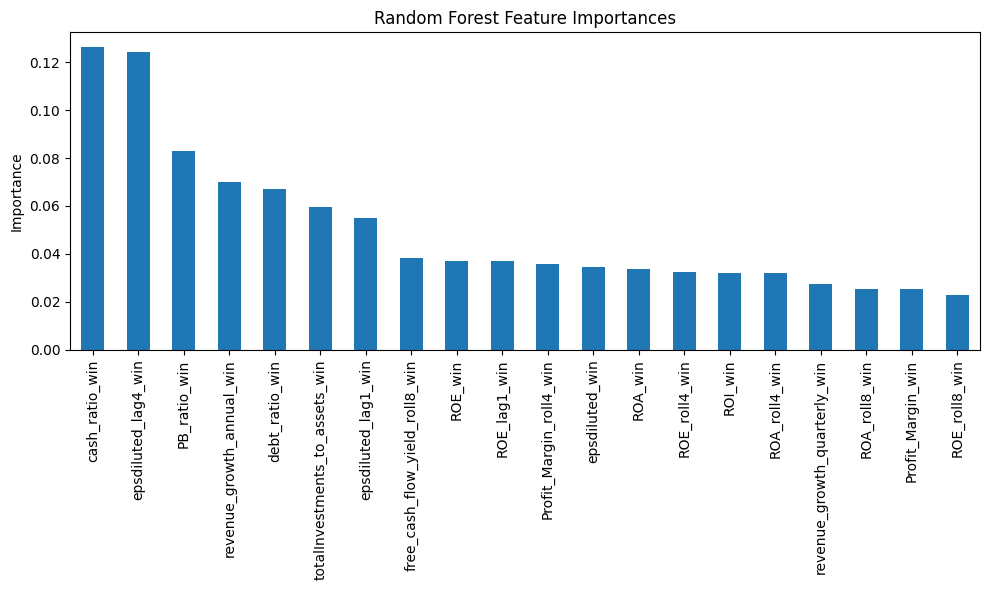

In [8]:
# fin_df = final_df[final_df['Sector'] == 'Financial Services']
fin_df['accepted_date'] = pd.to_datetime(fin_df['accepted_date'])

# Time-based train/test split to make sure there is no data leakage
train_cutoff = pd.Timestamp("2016-01-01")
# train_cutoff = pd.Timestamp("2011-01-01")
# test_cutoff_end = pd.Timestamp("2023-06-30")
test_cutoff_end = pd.Timestamp("2023-03-31")

train_df = fin_df[fin_df['accepted_date'] < train_cutoff].copy()
test_df  = fin_df[(fin_df['accepted_date'] >= train_cutoff) & 
                  (fin_df['accepted_date'] <= test_cutoff_end)].copy()

# Define target and features
target = 'good_stock'

features = [
    'ROA_win', 'ROE_win', 'ROI_win', 'ROE_lag1_win', 'ROE_roll4_win', 'ROE_roll8_win', 'ROA_roll4_win', 'ROA_roll8_win',
    'Profit_Margin_win', 'Profit_Margin_roll4_win',
    'PB_ratio_win',
    'cash_ratio_win',
    'free_cash_flow_yield_roll8_win',
    'epsdiluted_win', 'epsdiluted_lag1_win', 'epsdiluted_lag4_win',
    'revenue_growth_quarterly_win', 'revenue_growth_annual_win',
    'totalInvestments_to_assets_win',
    'debt_ratio_win'
]


# Replace infinite values with NaN and drop rows with missing values, NAN, in the training and testing dataframes
train_df = train_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.replace([np.inf, -np.inf], np.nan)

train_df = train_df.dropna(subset=features + [target])
test_df = test_df.dropna(subset=features + [target])

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]


print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Time series cross-validation and grid search
tscv = TimeSeriesSplit(n_splits=3)
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_split': [2],
    'max_features': [None]
}

rf_clf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid_rf,
                              scoring='roc_auc',
                              cv=tscv,
                              verbose=1,
                              n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search_rf.best_params_)

best_rf_model = grid_search_rf.best_estimator_

# Model evaluation on test set
y_pred = best_rf_model.predict(X_test)
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))

# Feature importance
importances = best_rf_model.feature_importances_
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Valid Trades Summary (first few rows):
  symbol_stock          entry_date           exit_date  trade_return  \
0           AB 2018-02-13 07:02:10 2019-02-13 07:17:51      0.279085   
1         ACGL 2019-02-28 16:14:41 2019-08-07 11:57:11      0.187714   
2          AGM 2022-05-09 16:13:40 2022-08-08 16:13:00      0.047393   
3          AGM 2022-11-07 16:13:38 2023-02-24 08:07:19      0.223550   
4          AJG 2018-05-07 16:20:21 2018-07-27 15:45:37      0.019420   

   position_size  hold_periods          exit_reason Quarter  
0    1394.143731             2        signal_change  2019Q1  
1     643.793683             3        signal_change  2019Q3  
2     208.114351             2  fundamentals_change  2022Q3  
3     185.964696             2        signal_change  2023Q1  
4     319.675583             2        signal_change  2018Q3  

Enhanced Trade-Level Backtest Performance:
Quarterly Trade Returns:
 2016Q1   -0.010000
2016Q2    0.069947
2016Q3    0.065814
2016Q4   -0.027888
2017Q1    

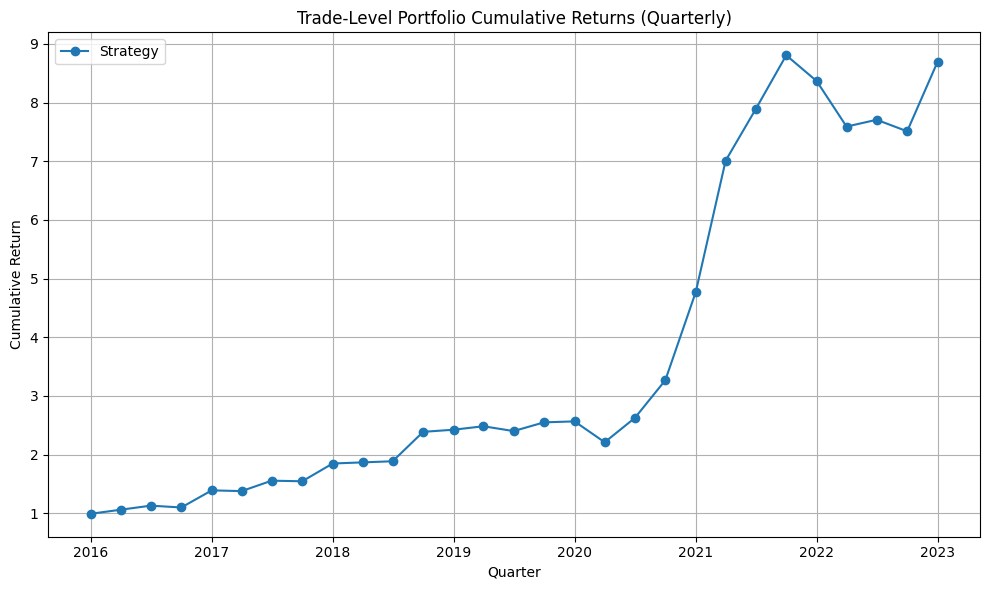

In [9]:
# To hold a more realistic portfolio, we use the enhanced backtest to account for holding a stock until the signal changes - 
# either due to a negative return, a deterioration of fundamentals, or a threshold for profit/loss. 

# Enhanced Backtest

transaction_cost = 0.005  # 0.5% per trade side
slippage = 0.002          # 0.2% slippage per trade side

# Add predictions to test_df
predicted_signal = best_rf_model.predict(X_test)
test_df.loc[X_test.index, 'predicted_signal'] = predicted_signal

test_sim = test_df.sort_values(['symbol_stock', 'accepted_date']).copy()

# Select simulation function

# simulation_function = backtest.simulate_trades_for_stock_baseline
simulation_function = backtest.simulate_trades_for_stock_enhanced

all_trades = []
for symbol, group in test_sim.groupby('symbol_stock'):
    trades = simulation_function(group, transaction_cost, slippage,
                                 stop_loss=-0.05, take_profit=1.0,
                                 max_hold_periods=20, risk_per_trade=1000, account_balance=100000)
    all_trades.extend(trades)

trades_df = pd.DataFrame(all_trades)

if not trades_df.empty:
    trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
    trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])
    trades_df['Quarter'] = trades_df['exit_date'].dt.to_period('Q')
    
    # Exclude trades that were force-closed immediately (no holding period).
    valid_trades_df = trades_df[trades_df['entry_date'] < trades_df['exit_date']]
    
    print("Valid Trades Summary (first few rows):")
    print(valid_trades_df.head())
    
    quarterly_trade_returns = valid_trades_df.groupby('Quarter')['trade_return'].mean()
    all_quarters = pd.period_range(start=test_sim['accepted_date'].min().to_period('Q'),
                                   end=test_sim['accepted_date'].max().to_period('Q'),
                                   freq='Q')
    quarterly_trade_returns = quarterly_trade_returns.reindex(all_quarters, fill_value=-0.01)
    
    cumulative_returns = (1 + quarterly_trade_returns).cumprod()
    n_quarters = len(cumulative_returns)
    observed_annualized_return = (cumulative_returns.iloc[-1]) ** (4 / n_quarters) - 1
    sharpe_ratio = quarterly_trade_returns.mean() / quarterly_trade_returns.std() * np.sqrt(4)
    
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    print("\nEnhanced Trade-Level Backtest Performance:")
    print("Quarterly Trade Returns:\n", quarterly_trade_returns)
    print("Cumulative Portfolio Returns:\n", cumulative_returns)
    print(f"Observed Annualized Return: {observed_annualized_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns.index.to_timestamp(), cumulative_returns, marker='o', label='Strategy')
    plt.title("Trade-Level Portfolio Cumulative Returns (Quarterly)")
    plt.xlabel("Quarter")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No trades were generated from the simulation.")

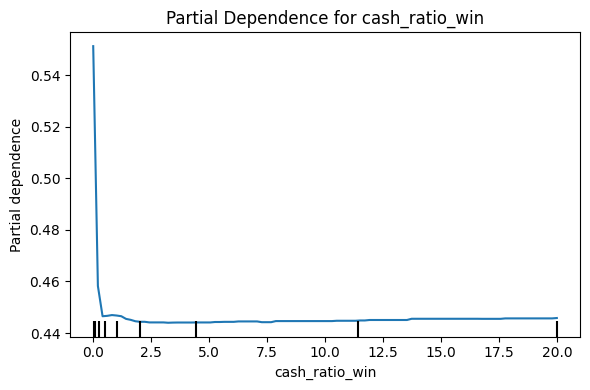

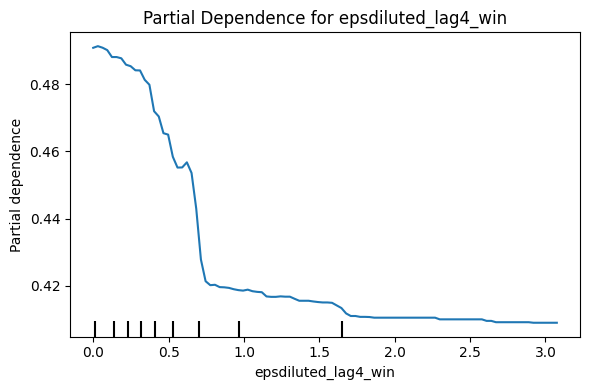

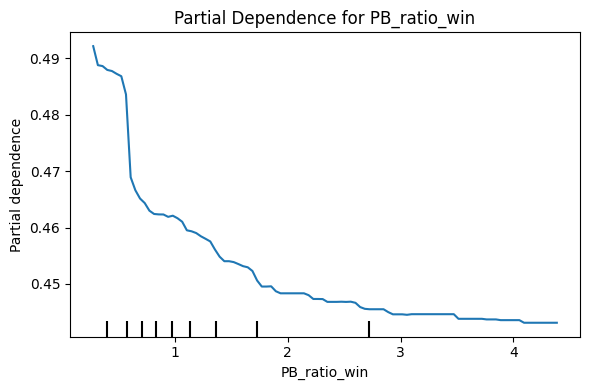

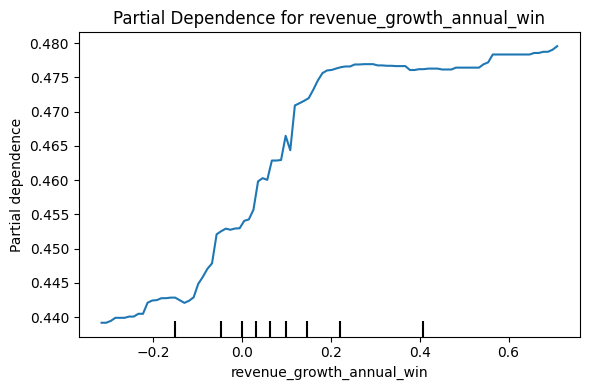

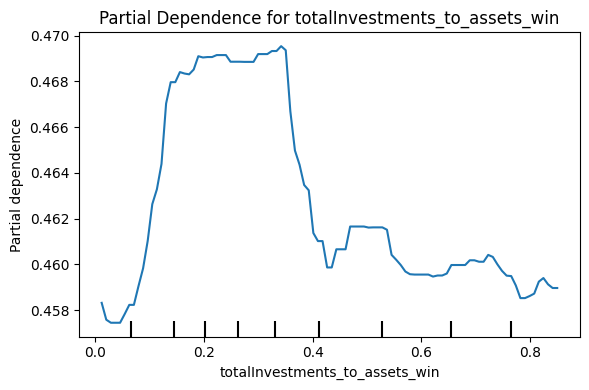

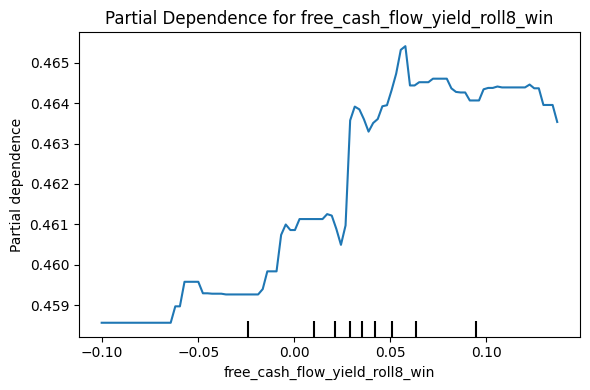

In [10]:
# Using a Partial Dependence Plot to see the marginal effect of a feature on the predicted outcome of the model.
# It shows how the predicted response, in isolation, is influenced by the chosen feature.
# We can see that a higher lagged EPS might correlate with a lower probability of outperforming the SP500. 
# We can interpret as "high EPS in the past" might leave little room or value to grow. 
# Looking for "great companies at a fair value".
# Lower P/B ratio is interpreted as "value" aka undervalued stocks. The PDP for P/B ratio shows that 
# higher P/B ratios are associated with a lower chance of having a good relative return.
features_to_plot = ['cash_ratio_win', 'epsdiluted_lag4_win', 'PB_ratio_win', 
                    'revenue_growth_annual_win', 'totalInvestments_to_assets_win', 'free_cash_flow_yield_roll8_win',]

for feature in features_to_plot:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        best_rf_model,
        X_train,
        features=[feature],
        ax=ax
    )
    plt.title(f"Partial Dependence for {feature}")
    plt.tight_layout()
    plt.show()


Bootstrap Analysis on Annualized Return:
Mean Annualized Return (bootstrap): 20.91%
95% Confidence Interval: [5.60%, 36.87%]
P-value for annualized return = 0: 0.0062


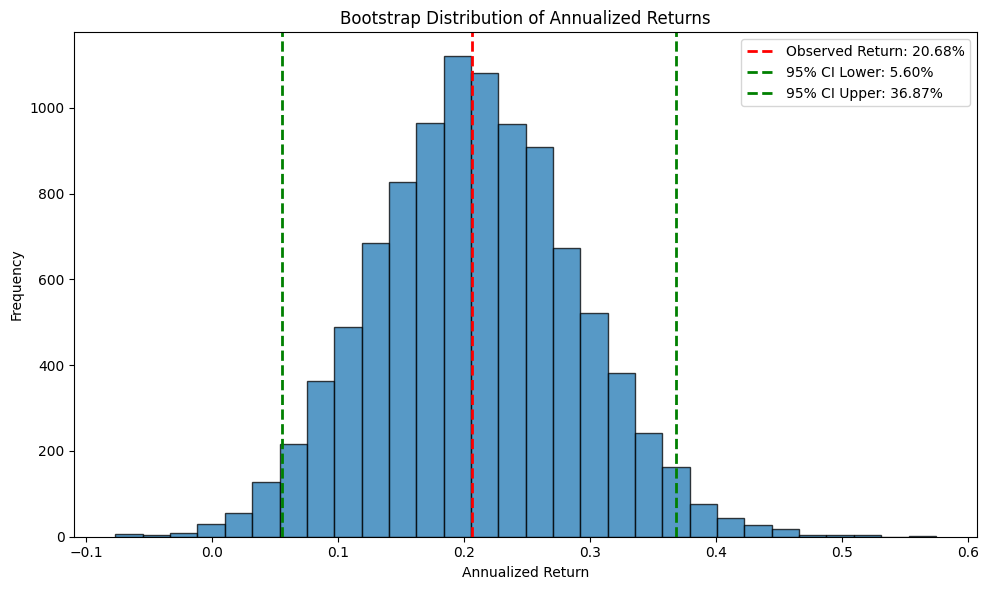

In [ ]:
# Implementing bootstrapping, a resampling technique which can be used to approx. the sampling distribution
# of a statistic (in this case, the quarterly returns) by repeatedly drawing samples from the data with replacement.
n_iterations = 10000 
bootstrap_annualized_returns = []
quarterly_returns_array = quarterly_trade_returns.values

for i in range(n_iterations):
    # Resample quarterly returns with replacement
    bootstrap_sample = np.random.choice(quarterly_returns_array, size=len(quarterly_returns_array), replace=True)
    cumulative_return_boot = np.prod(1 + bootstrap_sample)
    annualized_return_boot = cumulative_return_boot**(4/len(bootstrap_sample)) - 1
    bootstrap_annualized_returns.append(annualized_return_boot)

bootstrap_annualized_returns = np.array(bootstrap_annualized_returns)
ci_lower = np.percentile(bootstrap_annualized_returns, 2.5)
ci_upper = np.percentile(bootstrap_annualized_returns, 97.5)

if observed_annualized_return >= 0:
    p_value = 2 * np.mean(bootstrap_annualized_returns <= 0)
else:
    p_value = 2 * np.mean(bootstrap_annualized_returns >= 0)
p_value = min(p_value, 1.0)

print("\nBootstrap Analysis on Annualized Return:")
print(f"Mean Annualized Return (bootstrap): {np.mean(bootstrap_annualized_returns):.2%}")
print(f"95% Confidence Interval: [{ci_lower:.2%}, {ci_upper:.2%}]")
print(f"P-value for annualized return = 0: {p_value:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(bootstrap_annualized_returns, bins=30, alpha=0.75, edgecolor='black')
plt.axvline(observed_annualized_return, color='red', linestyle='dashed', linewidth=2, 
            label=f'Observed Return: {observed_annualized_return:.2%}')
plt.axvline(ci_lower, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Lower: {ci_lower:.2%}')
plt.axvline(ci_upper, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Upper: {ci_upper:.2%}')
plt.title("Bootstrap Distribution of Annualized Returns")
plt.xlabel("Annualized Return")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


[Hierarchical (Block Bootstrap) Annualized Return Analysis:
Mean Annualized Return (bootstrap): 21.10%
95% Confidence Interval: [5.74%, 36.93%]
P-value for annualized return = 0: 0.0061


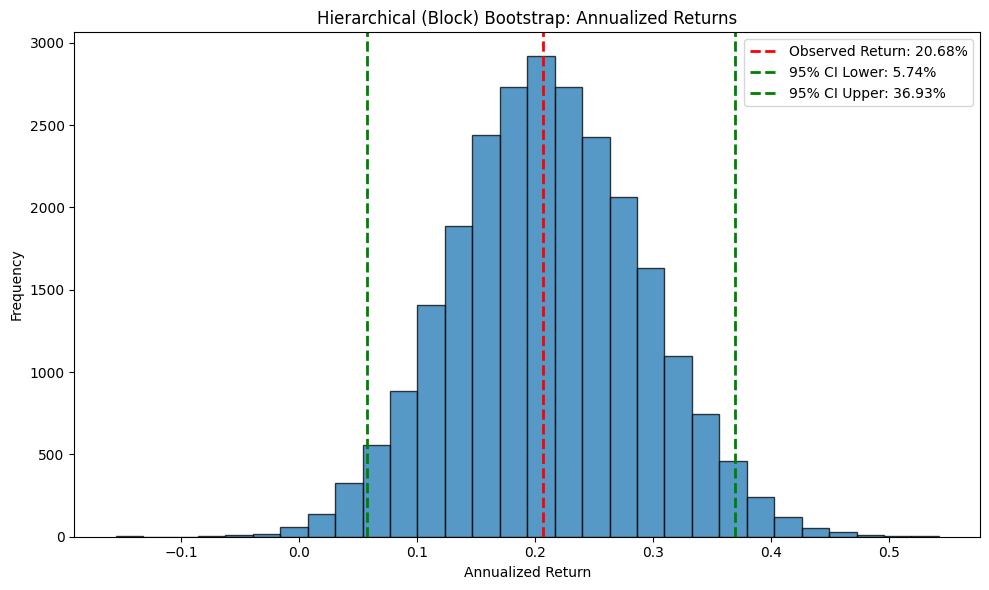

In [ ]:
# The bootstrapping above uses the quarterly returns. This is somewhat of an issue because there is only around 29 quarters to
# select from. To bootstrap in a different way, we resample at the trade level for each quarter, aggregate to the quarterly level
# and then bootstrap again. It accounts for variability within a quarter and between quarters, while also enabling use of the trades
# to sample from. This method is called Hierarchical, or Block, Bootstrapping.
def bootstrap_quarterly_return(trades_in_quarter, n_bootstrap=1000):
    """
    For a given quarter (DataFrame of trades), perform an inner bootstrap 
    to compute an aggregated quarterly return (here using the mean return).
    """
    boot_returns = []
    trade_returns = trades_in_quarter['trade_return'].values
    n_trades = len(trade_returns)
    for _ in range(n_bootstrap):
        # Resample trades for this quarter with replacement
        boot_sample = np.random.choice(trade_returns, size=n_trades, replace=True)
        boot_returns.append(np.mean(boot_sample))
    return np.mean(boot_returns)

# Get all unique quarters from trades_df
quarters = trades_df['Quarter'].unique()

# Bootstrap the quarterly return for each quarter using trade-level data
bootstrapped_quarterly_returns = {}
n_inner_bootstrap = 2000  # inner bootstrap iterations per quarter

for q in quarters:
    trades_q = trades_df[trades_df['Quarter'] == q]
    bootstrapped_quarterly_returns[str(q)] = bootstrap_quarterly_return(trades_q, n_bootstrap=n_inner_bootstrap)

boot_quarterly_returns = pd.Series(bootstrapped_quarterly_returns)
# Use the full quarter index from the simulation (all_quarters was defined earlier)
boot_quarterly_returns = boot_quarterly_returns.reindex(all_quarters.astype(str), fill_value=-0.01)

# Perform an outer bootstrap on the aggregated quarterly returns
n_outer_bootstrap = 25000
bootstrap_annualized_returns_hier = []
quarterly_returns_array = boot_quarterly_returns.values

for i in range(n_outer_bootstrap):
    # Resample the quarterly blocks - each block being a bootstrapped quarterly return)
    bootstrap_sample = np.random.choice(quarterly_returns_array, size=len(quarterly_returns_array), replace=True)
    cumulative_return = np.prod(1 + bootstrap_sample)
    annualized_return = cumulative_return**(4 / len(bootstrap_sample)) - 1
    bootstrap_annualized_returns_hier.append(annualized_return)

bootstrap_annualized_returns_hier = np.array(bootstrap_annualized_returns_hier)
ci_lower_hier = np.percentile(bootstrap_annualized_returns_hier, 2.5)
ci_upper_hier = np.percentile(bootstrap_annualized_returns_hier, 97.5)

if observed_annualized_return >= 0:
    p_value_hier = 2 * np.mean(bootstrap_annualized_returns_hier <= 0)
else:
    p_value_hier = 2 * np.mean(bootstrap_annualized_returns_hier >= 0)
p_value_hier = min(p_value_hier, 1.0)

print("\n[Hierarchical (Block Bootstrap) Annualized Return Analysis:")
print(f"Mean Annualized Return (bootstrap): {np.mean(bootstrap_annualized_returns_hier):.2%}")
print(f"95% Confidence Interval: [{ci_lower_hier:.2%}, {ci_upper_hier:.2%}]")
print(f"P-value for annualized return = 0: {p_value_hier:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(bootstrap_annualized_returns_hier, bins=30, alpha=0.75, edgecolor='black')
plt.axvline(observed_annualized_return, color='red', linestyle='dashed', linewidth=2, 
            label=f'Observed Return: {observed_annualized_return:.2%}')
plt.axvline(ci_lower_hier, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Lower: {ci_lower_hier:.2%}')
plt.axvline(ci_upper_hier, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Upper: {ci_upper_hier:.2%}')
plt.title("Hierarchical (Block) Bootstrap: Annualized Returns")
plt.xlabel("Annualized Return")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


No-Predictability Benchmark Performance (Random Signals):
Quarterly Trade Returns:
 2016Q1   -0.010000
2016Q2    0.147145
2016Q3    0.047543
2016Q4    0.068942
2017Q1    0.221172
2017Q2   -0.031997
2017Q3    0.029551
2017Q4    0.072617
2018Q1    0.025600
2018Q2   -0.054637
2018Q3    0.014612
2018Q4   -0.061486
2019Q1   -0.007653
2019Q2    0.014623
2019Q3    0.003997
2019Q4    0.000363
2020Q1   -0.016031
2020Q2   -0.172977
2020Q3    0.128953
2020Q4    0.095184
2021Q1    1.041789
2021Q2    0.120160
2021Q3    0.364069
2021Q4    0.104507
2022Q1    0.034191
2022Q2   -0.101974
2022Q3   -0.009698
2022Q4   -0.019551
2023Q1   -0.002662
Freq: Q-DEC, Name: trade_return, dtype: float64
Cumulative Portfolio Returns:
 2016Q1    0.990000
2016Q2    1.135674
2016Q3    1.189667
2016Q4    1.271685
2017Q1    1.552947
2017Q2    1.503257
2017Q3    1.547679
2017Q4    1.660067
2018Q1    1.702565
2018Q2    1.609541
2018Q3    1.633061
2018Q4    1.532650
2019Q1    1.520920
2019Q2    1.543161
2019Q3    1.549329


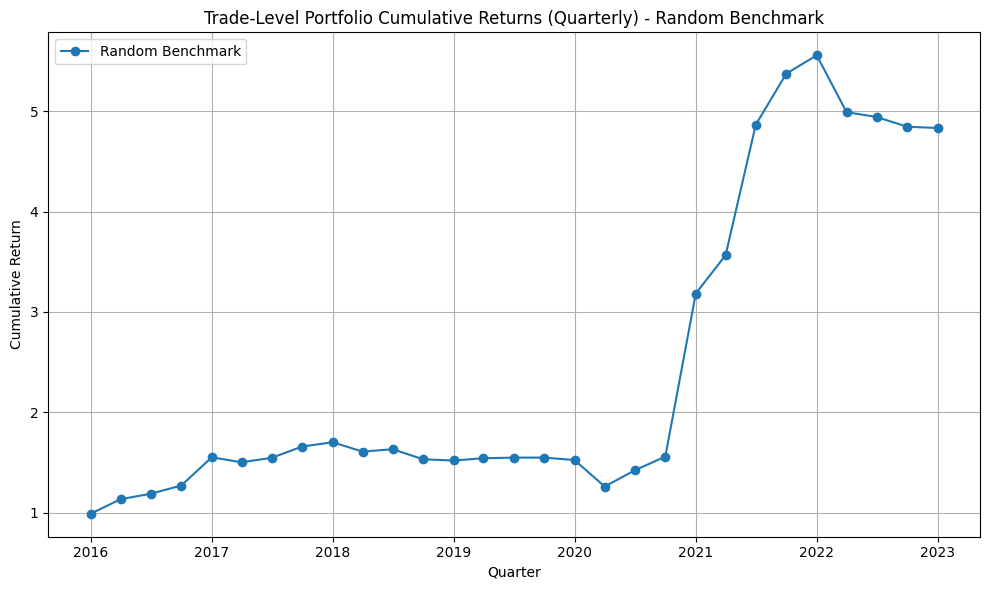

In [ ]:
# No-Predictability (Random Signal) Benchmark
# Generate random signals that preserve the same positive rate (%) as the model's predictions.
# This ensures the overall frequency of trades is similar to the model.

# Calculate the positive rate from the model predictions
p_rate = test_sim['predicted_signal'].mean()
np.random.seed(42)

# Create a new random signal column using a Bernoulli process with probability p_rate, and then use the random signal for 
# simulation by copying test_sim and replacing the predicted_signal
test_sim['random_signal'] = np.random.binomial(1, p_rate, size=len(test_sim))

test_sim_random = test_sim.copy()
test_sim_random['predicted_signal'] = test_sim_random['random_signal']

# Run simulation
all_trades_random = []
for symbol, group in test_sim_random.groupby('symbol_stock'):
    trades = simulate_trades_for_stock_enhanced(
        group,
        transaction_cost,
        slippage,
        stop_loss=-0.1,
        take_profit=0.10,
        max_hold_periods=6,
        risk_per_trade=1000,
        account_balance=100000
    )
    all_trades_random.extend(trades)

trades_df_random = pd.DataFrame(all_trades_random)

if trades_df_random.empty:
    print("No trades were simulated for the random benchmark.")
else:
    # Create a quarterly time period for aggregation
    trades_df_random['entry_date'] = pd.to_datetime(trades_df_random['entry_date'])
    trades_df_random['exit_date'] = pd.to_datetime(trades_df_random['exit_date'])
    trades_df_random['Quarter'] = trades_df_random['exit_date'].dt.to_period('Q')

    # Aggregate quarterly trade returns (using mean return per quarter)
    quarterly_trade_returns_random = trades_df_random.groupby('Quarter')['trade_return'].mean()

    all_quarters = pd.period_range(
        start=test_sim['accepted_date'].min().to_period('Q'),
        end=test_sim['accepted_date'].max().to_period('Q'),
        freq='Q'
    )
    quarterly_trade_returns_random = quarterly_trade_returns_random.reindex(all_quarters, fill_value=-0.01)

    # Compute cumulative portfolio returns from quarterly returns
    cumulative_returns_random = (1 + quarterly_trade_returns_random).cumprod()
    n_quarters_random = len(cumulative_returns_random)
    observed_annualized_return_random = (cumulative_returns_random.iloc[-1])**(4/n_quarters_random) - 1
    sharpe_ratio_random = (quarterly_trade_returns_random.mean() /
                           quarterly_trade_returns_random.std()) * np.sqrt(4)
    peak_random = cumulative_returns_random.cummax()
    drawdown_random = (cumulative_returns_random - peak_random) / peak_random
    max_drawdown_random = drawdown_random.min()

    print("\nNo-Predictability Benchmark Performance (Random Signals):")
    print("Quarterly Trade Returns:\n", quarterly_trade_returns_random)
    print("Cumulative Portfolio Returns:\n", cumulative_returns_random)
    print(f"Observed Annualized Return: {observed_annualized_return_random:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio_random:.2f}")
    print(f"Maximum Drawdown: {max_drawdown_random:.2%}")

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns_random.index.to_timestamp(), cumulative_returns_random,
             marker='o', label='Random Benchmark')
    plt.title("Trade-Level Portfolio Cumulative Returns (Quarterly) - Random Benchmark")
    plt.xlabel("Quarter")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

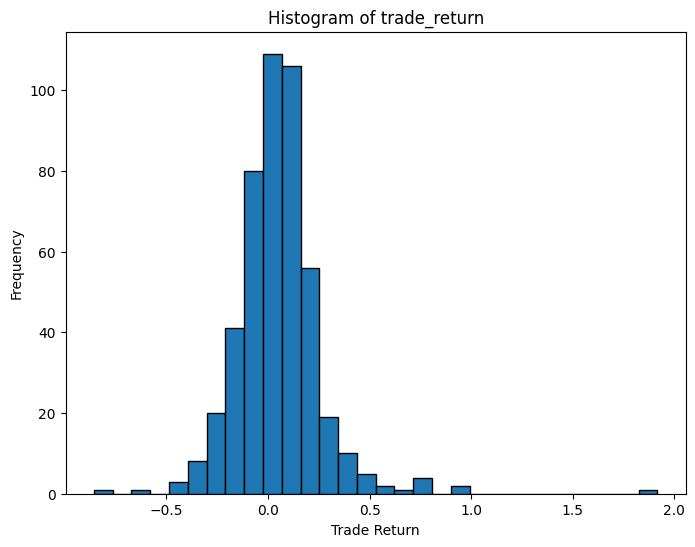

In [55]:
plt.figure(figsize=(8, 6))
plt.hist(trades_df['trade_return'], bins=30, edgecolor='black')
plt.title('Histogram of trade_return')
# plt.xlim(-1, 5)
plt.xticks()
plt.xlabel('Trade Return')
plt.ylabel('Frequency')
plt.show()